
# Лабораторная работа №2

## Камышева Татьяна

## 15-АС

## Вариант 9

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.linear_model import perceptron
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from matplotlib.pylab import rc, plot

df = pd.read_csv(r'titanic3.csv', sep=';')

### 1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).


| Атрибут | Описание | Параметры |
|---------|---------:|----------:|
| pclass | класс билета	| 1 - 1 класс; 2 - 2 класс; 3 - 3 класс |
| survived | выживание	| 0 - Нет ;1 - Да |
| name	| имя	| любой
| sex |	пол	| female - женский, male - мужской
| age | возраст	| любой числовой
| sibsp	 | число братьев, сестер, супругов на борту	| любой числовой
| parch |	число родителей, детей на ботру	| любой числовой
| fare |	цена билета(британский фунт) | любой числовой
| ticket |	номер билета |	любой
| cabin |	номер каюты |	любой
| embarked	 |порт посадки |	C = Cherbourg, Q = Queenstown, S = Southampton
| boat	| номер спасательной шлюпки |	любой
| body |	идентификационный номер тела |	любой
| home.dest | Дом/Назначение |	любой

### 2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;

In [151]:
df.shape

(1310, 14)

In [152]:
df = df.drop_duplicates()
df.shape

(1310, 14)

### 3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

    Died: 809 nSurvived: 500


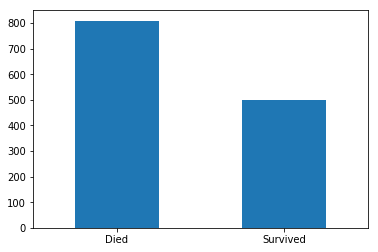

In [153]:
print(fmt_str.format("Died", "Survived", value_counts));
value_counts.plot(kind='bar');
plt.xticks(np.arange(2), ("Died", "Survived"), rotation=0)
plt.show()

Количество элементов заметно отличается, поэтому будем считать, что классы несбалансированы.
Будем использовать ROC-кривую, поскольку она дает адекватную оценку качества работы алгоритма, где классы несбалансированы и их размеры выборки отличаются друг от друга несущественно (не на порядок).

### 4.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);

In [154]:
# При решении задачи некоторые признаки будут лишними. Они не влияют на классификацию или являются избыточными
list_to_drop = ['body', 'boat', 'name', 'cabin', 'ticket', 'home.dest']
df.drop(list_to_drop, axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29,0.0,0.0,"211,3375",S
1,1.0,1.0,male,"0,9167",1.0,2.0,"151,5500",S
2,1.0,0.0,female,2,1.0,2.0,"151,5500",S
3,1.0,0.0,male,30,1.0,2.0,"151,5500",S
4,1.0,0.0,female,25,1.0,2.0,"151,5500",S


In [155]:
def cast(obj):
    if type(obj) == str:
        return float(obj.replace(',', '.'))
    else:
        return obj
df['age'] = df['age'].apply(lambda x: cast(x))
df['fare'] = df['fare'].apply(lambda x: cast(x))
df['pclass'] = df['pclass'].apply(lambda x: str(x))

# выделим категориальные и числовые признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']
print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['survived', 'age', 'sibsp', 'parch', 'fare']
categorial:  ['pclass', 'sex', 'embarked']


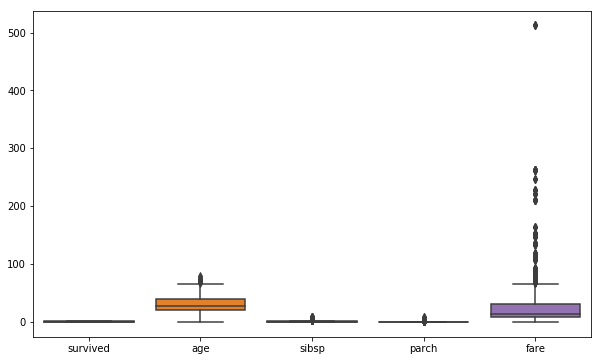

In [156]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

In [157]:
# заполним пропущенные значения параметра age медианными,
# чтобы не потерять много данных при очистке строк с пустыми полями
df['age'] = df['age'].fillna(df['age'].median())
df = df.dropna().reset_index(drop=True)
df.count()

pclass      1306
survived    1306
sex         1306
age         1306
sibsp       1306
parch       1306
fare        1306
embarked    1306
dtype: int64

In [158]:
# нормализуем
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,1.0,1.0,male,0.009395,0.125,0.222222,0.295806,S
2,1.0,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,1.0,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,1.0,0.0,female,0.311064,0.125,0.222222,0.295806,S


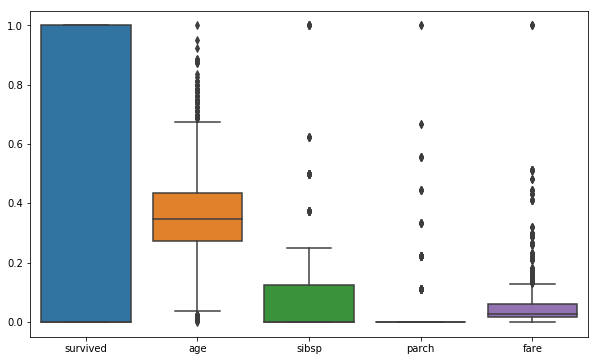

In [159]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

### 5.	Выполните замену категориальных признаков

In [160]:
# выделим бинарные и небинарные признаки
binary_columns = [i for i in categorial_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]

# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(1306, 12)


,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,survived,sex,age,sibsp,parch,fare
0,1,0,0,0,0,1,1.0,0,0.361169,0.000,0.000000,0.412503
1,1,0,0,0,0,1,1.0,1,0.009395,0.125,0.222222,0.295806
2,1,0,0,0,0,1,0.0,0,0.022964,0.125,0.222222,0.295806
3,1,0,0,0,0,1,0.0,1,0.373695,0.125,0.222222,0.295806
4,1,0,0,0,0,1,0.0,0,0.311064,0.125,0.222222,0.295806


### 6.	Оцените корреляцию между признаками и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);

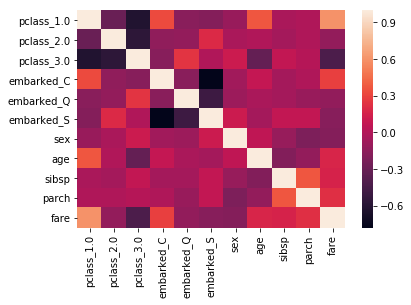

In [161]:
df_corr = df.drop('survived', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

Видна сильная отрицательная зависимость между параметрами, которые были выделены dummy-кодированием, что естественно. Слабая зависимость между parch и sibsp, что тоже нормально. Средняя зависимость между fate(цена билета) и уровнем класса говорит, что параметры близки друг другу, и есть избыточные данные.

### 7.	Заполните пропущенные значения в данных;

In [162]:
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 12 columns):
pclass_1.0    1306 non-null uint8
pclass_2.0    1306 non-null uint8
pclass_3.0    1306 non-null uint8
embarked_C    1306 non-null uint8
embarked_Q    1306 non-null uint8
embarked_S    1306 non-null uint8
survived      1306 non-null float64
sex           1306 non-null int64
age           1306 non-null float64
sibsp         1306 non-null float64
parch         1306 non-null float64
fare          1306 non-null float64
dtypes: float64(5), int64(1), uint8(6)
memory usage: 68.9 KB


### 8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 

In [163]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('survived', axis=1), df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(914, 11)
(392, 11)


In [164]:
# найдем оптимальный радиус для классификатора ближайших соседей
rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(0, 5, 0.25)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.7910284463894968 	 at radius: 0.5
test score:  0.829081632653


In [165]:
# линейный классификатор

slf = sk.linear_model.Perceptron()
paramsearch = GridSearchCV(estimator=slf, param_grid=dict(alpha=np.linspace(0,2,20)[1:],n_iter=[int(50)]), n_jobs=int(10))
paramsearch.fit(X_train, y_train)
best_score = paramsearch.best_score_
selected_alpha = paramsearch.best_estimator_.alpha
print('best score=',best_score,'at alpha',selected_alpha)
best_n_iter = paramsearch.best_estimator_.n_iter
best_n_jobs = paramsearch.best_estimator_.n_jobs

dtc = sk.linear_model.Perceptron(alpha=selected_alpha,n_iter=best_n_iter,n_jobs=best_n_jobs)
dtc.fit(X_train, y_train)
test_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', test_score)

best score= 0.62472647702407 at alpha 0.105263157895
test score:  0.803571428571


In [166]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        '''
        
        General description. 
        Determines the probability that a test instance matching a class.
        
        Algorithm. 
        We'll go through the zero radius to the double classifier radius
        with the elementary step(dr). If an instance lies along the:
        * Zero raduis+dr - corresponds 100%
        * Classifier raduis+dr - corresponds 50%
        * Double classifier raduis+dr and beyond it - corresponds 0%
        There are intermediate values of percents. Each step corresponds
        to its own percentage value. If predicted instance changes its 
        class, this instance belongs to the current radius and it is 
        assigned the appropriate percentage. 
        
        fit method built-in
        '''
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),2), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

In [167]:
clf_isotonic = CalibratedClassifierCV(slf, cv=10, method='isotonic')
clf_isotonic.fit(X_train, y_train)
probas_slf0 = clf_isotonic.predict_proba(X_test)
clf_isotonic.fit(X_train, y_train)
probas_slf1 = clf_isotonic.predict_proba(X_test)

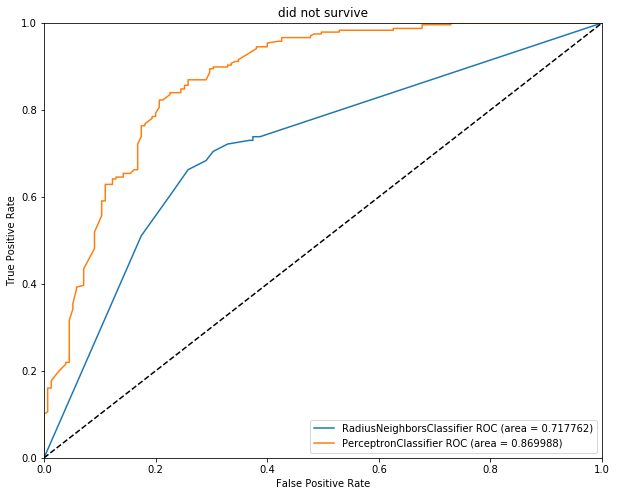

In [168]:
# ROC график 

# --- класс умерших ---
plt.figure(figsize=(10,8))
# K соседей
mrnc = MyRadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test, probas_mrnc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

# Персептрон
tpr, fpr, thresholds = roc_curve(y_test, probas_slf0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('PerceptronClassifier', roc_auc)) 

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('did not survive')
plt.show()

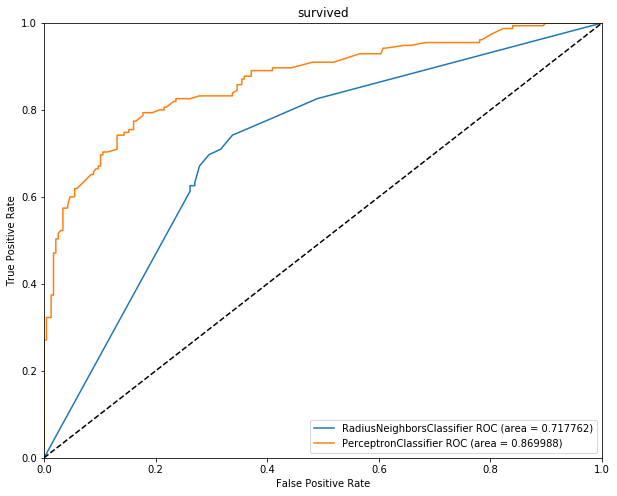

In [169]:
# --- класс выживших ---
plt.figure(figsize=(10,8))
# K соседей
mrnc = MyRadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_test, probas_mrnc1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 
# PerceptronClassifier
fpr, tpr, thresholds = roc_curve(y_test, probas_slf1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('PerceptronClassifier', roc_auc))   
# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

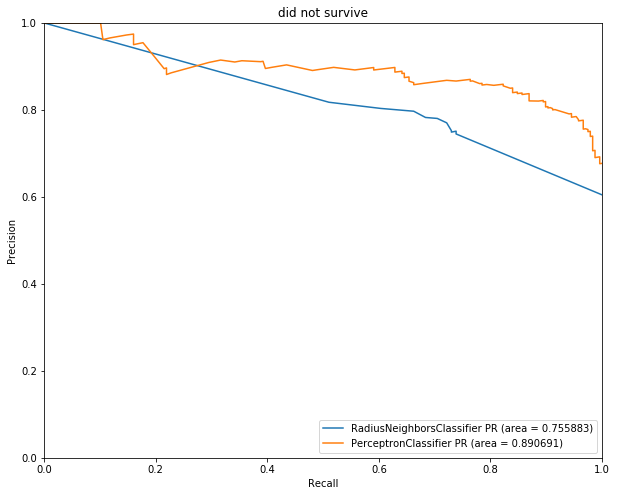

In [170]:
# PR график 

# --- класс умерших ---
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_mrnc1[:,0])
aps_mrnc1 = average_precision_score(y_test_invers,probas_mrnc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# Персептрон
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_slf1[:,0])
aps_slf1 = average_precision_score(y_test_invers,probas_slf1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('PerceptronClassifier',  aps_slf1))
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('did not survive')
plt.show()

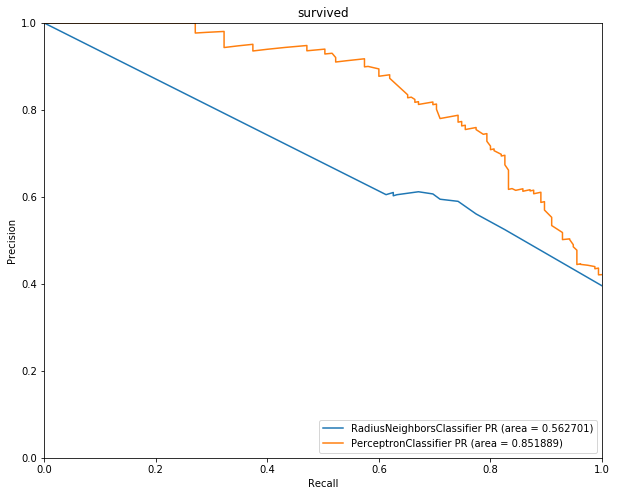

In [171]:
# --- класс выживших ---
plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test,probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# Персептрон
precision, recall, thresholds = precision_recall_curve(y_test, probas_slf1[:,1])
aps_slf1 = average_precision_score(y_test,probas_slf1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('PerceptronClassifier',  aps_slf1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()


### 9 Сравните кривые для классификаторов, указанных в задании, сделайте выводы
Данные классификаторы имеют примерно одинаковые показатели качества относительно PR и ROC кривых. 
В целом, данные классификаторы решают задачу предсказания класса с вероятностью 0.71~0.89, что безусловно хорошо, хотя и не слишком точно.
Для одного из реузльтатов данные колеблятся в пределах 0.56~0.85, что близко к случайному.  
Есть пути улучшить результаты: подобрать более подходящий под задачу классификатор, осуществить несколько иной подход к подготовке данных в соответсвие с выбранным классификатором.